In [1]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET

In [3]:
#%cd cvobjectai

In [5]:
# Define the path
path = 'dogcat'
# Get the list of all files in the folder
allFiles = glob.glob(path + '/*.xml')
allFiles

['dogcat\\100_png.rf.3a962ab3223591a63aac9ff6fb036200.xml',
 'dogcat\\100_png.rf.a824ac5e3a46248205b8f88a48d8b4df.xml',
 'dogcat\\100_png.rf.da78f3940d2be4224f9ce038c97ca06b.xml',
 'dogcat\\101_png.rf.46c1578e10e3b0093cf4398aa6b973f7.xml',
 'dogcat\\101_png.rf.817051e290dfe1393744062f23c5b704.xml',
 'dogcat\\101_png.rf.ce5c128258df1e7cfcadc5abc154eb33.xml',
 'dogcat\\102_png.rf.82b8c5a8e8a6c37ef7b73695d4e91150.xml',
 'dogcat\\103_png.rf.765a269b2feb0b2998c45413b3d90844.xml',
 'dogcat\\103_png.rf.a9ac35d4b6385c369573fac47d3ab0dd.xml',
 'dogcat\\103_png.rf.e1db4161f36e9ce50ac750b520437c83.xml',
 'dogcat\\104_png.rf.1a7073ba61e7a8fe7f55b6feb636dcf6.xml',
 'dogcat\\105_png.rf.d39da144d3b70b62b564516efda64ea4.xml',
 'dogcat\\106_png.rf.91a3bbe10038ff5c9c4da6d856f98ef6.xml',
 'dogcat\\106_png.rf.f4edc0f68d22ec74c8e7d4b23364f47b.xml',
 'dogcat\\107_png.rf.40dae8c4ce9ecf0fc498b41ba065a6bc.xml',
 'dogcat\\107_png.rf.8d101bf86544b98ac0d445d9d5fcd584.xml',
 'dogcat\\107_png.rf.c413796d4746a7628ed

In [6]:
# Get one of the files
xml_file = allFiles[0]
# Parse xml file and get the root
tree = ET.parse(xml_file)
root = tree.getroot()
# For each element of the root print the tag and the attribute
for child in root:
    print(child.tag, child.attrib)

folder {}
filename {}
path {}
source {}
size {}
segmented {}
object {}


In [7]:
filename = root.find('filename').text
filename

'100_png.rf.3a962ab3223591a63aac9ff6fb036200.jpg'

In [8]:
# Extract width and height of the image
width = int(root.find('size').find('width').text)
height = int(root.find('size').find('height').text)
print(width,height)

320 320


In [9]:
# Get all the 'object' elements
members = root.findall('object')
# Take the first one to extract the information as an example
member = members[0]
print(member.find('name').text)
print(member.find('bndbox').find('xmin').text)


dog
17


In [10]:
def xml_to_pd(path):
    """Iterates through all .xml files (generated by labelImg) in a given directory and combines
    them in a single Pandas dataframe.
 
    Parameters:
    ----------
    path : str
        The path containing the .xml files
    Returns
    -------
    Pandas DataFrame
        The produced dataframe
    """
 
    xml_list = []
    # List down all the files within the path
    for xml_file in glob.glob(path + '/*.xml'):
        # Get the tree and the root of the xml files
        tree = ET.parse(xml_file)
        root = tree.getroot()
        # Get the filename, width and height from the respective elements
        filename = root.find('filename').text
        width = int(root.find('size').find('width').text)
        height = int(root.find('size').find('height').text)
        # Extract the class names and the bounding boxes of the classes
        for member in root.findall('object'):
            bndbox = member.find('bndbox')
            value = (filename,
                     width,
                     height,
                     member.find('name').text,
                     int(bndbox.find('xmin').text),
                     int(bndbox.find('ymin').text),
                     int(bndbox.find('xmax').text),
                     int(bndbox.find('ymax').text),
                     )
            xml_list.append(value)
    # Consolidate all the information into a data frame
    column_name = ['filename', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [11]:
data_df = xml_to_pd(path)
data_df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,100_png.rf.3a962ab3223591a63aac9ff6fb036200.jpg,320,320,dog,17,6,225,317
1,100_png.rf.a824ac5e3a46248205b8f88a48d8b4df.jpg,320,320,dog,3,1,239,320
2,100_png.rf.da78f3940d2be4224f9ce038c97ca06b.jpg,320,320,dog,13,3,229,320
3,101_png.rf.46c1578e10e3b0093cf4398aa6b973f7.jpg,320,320,dog,169,1,289,306
4,101_png.rf.817051e290dfe1393744062f23c5b704.jpg,320,320,dog,163,1,295,307
...,...,...,...,...,...,...,...,...
233,184_jpg.rf.a931b37a9fb9c45a5dbdc9359825a1e1.jpg,320,320,dog,53,48,278,307
234,18_jpg.rf.ec3cbaecf877b03d03f02f8899286380.jpg,320,320,cat,79,27,263,281
235,1_jpg.rf.01934072c68964e6c24dc30ef019dbc7.jpg,320,320,cat,72,34,299,305
236,1_jpg.rf.067b6a3f758a0aa3db5a3ef0004427e9.jpg,320,320,cat,61,25,310,314


In [12]:
data_df.to_csv('cvobject.csv',index=False)


In [19]:
#!pip install scikit-image
#!pip install scikit-learn 

In [20]:
import os
import glob
import pandas as pd
import io
import cv2
from skimage import feature
import skimage
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.svm import SVC
import numpy as np
import argparse
import pickle
import matplotlib.pyplot as plt
from random import sample
%matplotlib inline

In [21]:
# Positive Images
path = 'dogcat'
allFiles = glob.glob(path + '/*.jpg')
print(len(allFiles))
allFiles

220


['dogcat\\100_png.rf.3a962ab3223591a63aac9ff6fb036200.jpg',
 'dogcat\\100_png.rf.a824ac5e3a46248205b8f88a48d8b4df.jpg',
 'dogcat\\100_png.rf.da78f3940d2be4224f9ce038c97ca06b.jpg',
 'dogcat\\101_png.rf.46c1578e10e3b0093cf4398aa6b973f7.jpg',
 'dogcat\\101_png.rf.817051e290dfe1393744062f23c5b704.jpg',
 'dogcat\\101_png.rf.ce5c128258df1e7cfcadc5abc154eb33.jpg',
 'dogcat\\102_png.rf.82b8c5a8e8a6c37ef7b73695d4e91150.jpg',
 'dogcat\\103_png.rf.765a269b2feb0b2998c45413b3d90844.jpg',
 'dogcat\\103_png.rf.a9ac35d4b6385c369573fac47d3ab0dd.jpg',
 'dogcat\\103_png.rf.e1db4161f36e9ce50ac750b520437c83.jpg',
 'dogcat\\104_png.rf.1a7073ba61e7a8fe7f55b6feb636dcf6.jpg',
 'dogcat\\105_png.rf.d39da144d3b70b62b564516efda64ea4.jpg',
 'dogcat\\106_png.rf.91a3bbe10038ff5c9c4da6d856f98ef6.jpg',
 'dogcat\\106_png.rf.f4edc0f68d22ec74c8e7d4b23364f47b.jpg',
 'dogcat\\107_png.rf.40dae8c4ce9ecf0fc498b41ba065a6bc.jpg',
 'dogcat\\107_png.rf.8d101bf86544b98ac0d445d9d5fcd584.jpg',
 'dogcat\\107_png.rf.c413796d4746a7628ed

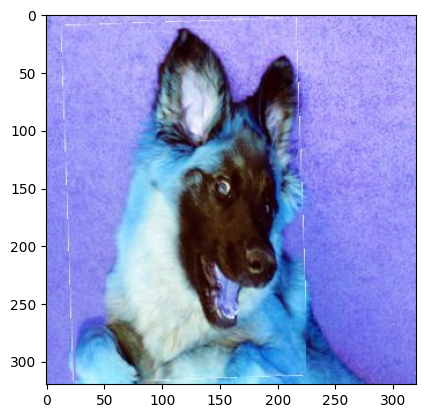

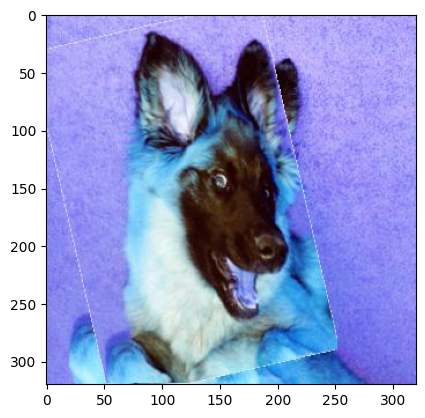

In [22]:
#  images
path = 'dogcat/'
roadFiles = glob.glob(path + '/*.jpg')
for imgPath in roadFiles[:2]:
    img = cv2.imread(imgPath)
    plt.imshow(img)
    plt.show()

In [25]:
# Reading the csv file
cvobject_df = pd.read_csv('cvobject.csv')
cvobject_df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,100_png.rf.3a962ab3223591a63aac9ff6fb036200.jpg,320,320,dog,17,6,225,317
1,100_png.rf.a824ac5e3a46248205b8f88a48d8b4df.jpg,320,320,dog,3,1,239,320
2,100_png.rf.da78f3940d2be4224f9ce038c97ca06b.jpg,320,320,dog,13,3,229,320
3,101_png.rf.46c1578e10e3b0093cf4398aa6b973f7.jpg,320,320,dog,169,1,289,306
4,101_png.rf.817051e290dfe1393744062f23c5b704.jpg,320,320,dog,163,1,295,307
...,...,...,...,...,...,...,...,...
233,184_jpg.rf.a931b37a9fb9c45a5dbdc9359825a1e1.jpg,320,320,dog,53,48,278,307
234,18_jpg.rf.ec3cbaecf877b03d03f02f8899286380.jpg,320,320,cat,79,27,263,281
235,1_jpg.rf.01934072c68964e6c24dc30ef019dbc7.jpg,320,320,cat,72,34,299,305
236,1_jpg.rf.067b6a3f758a0aa3db5a3ef0004427e9.jpg,320,320,cat,61,25,310,314


In [26]:
# Find the mean of the x dim and y dimensions of the pothole class
xdim = np.mean(cvobject_df[cvobject_df['class']=='dog']['xmax'] - cvobject_df[cvobject_df['class']=='dog']['xmin'])
ydim = np.mean(cvobject_df[cvobject_df['class']=='cat']['ymax'] - cvobject_df[cvobject_df['class']=='cat']['ymin'])
print(xdim,ydim)

189.21463414634147 141.42424242424244


In [27]:
# We will take the windows dimension as these dimensions rounded off
winDim = [80,40]

In [28]:
# Defining the hog structure
def hogFeatures(image,orientations,pixelsPerCell,cellsPerBlock,normalize=True):
    # Extracting the hog features from the image
    feat = feature.hog(image, orientations=orientations, pixels_per_cell=pixelsPerCell,cells_per_block = cellsPerBlock, transform_sqrt = normalize, block_norm="L1")
    feat[feat < 0] = 0
    return feat

In [29]:
# Defining the function for image augmentation
def imgAug(roi,ht,wd,extensive=True):
    # Initialise the empty list to store images
    rois = []
    # resize the ROI to the desired size
    roi = cv2.resize(roi, (ht,wd), interpolation=cv2.INTER_AREA)
    # Append the different images
    rois.append(roi)
    # Augment the image by flipping both horizontally and vertically
    rois.append(cv2.flip(roi, 1))
    if extensive:        
        rois.append(cv2.flip(roi, 0))
        rois.append(cv2.rotate(roi, cv2.ROTATE_90_CLOCKWISE))
        rois.append(cv2.rotate(roi, cv2.ROTATE_90_COUNTERCLOCKWISE))
        # Rotate to other angles
        for rot in [15,45,60,75,85]:
            # Get the rotation matrix
            rotMatrix = cv2.getRotationMatrix2D((ht/2,wd/2),rot,1)
            # ROtate the matrix using the rotation matrix
            rois.append(cv2.warpAffine(roi,rotMatrix,(ht,wd)))         
    return rois

In [30]:
# Functions to extract the bounding boxes and the hog features
def roiExtractor(row,path):
    img = cv2.imread(path + row['filename'])    
    # Get the bounding box elements
    bb = [int(row['xmin']),int(row['ymin']),int(row['xmax']),int(row['ymax'])]
    # Crop the image
    roi = img[bb[1]:bb[3], bb[0]:bb[2]]
    # Get the list of augmented images
    rois = imgAug(roi,80,40)
    return rois
 
def featExtractor(rois,data,labels,positive=True):
    for roi in rois:
        # Extract hog features
        feat = hogFeatures(roi,orientations,pixelsPerCell,cellsPerBlock,normalize=True)
        # Append data and labels
        data.append(feat)
        labels.append(int(1))        
    return data,labels

In [32]:
# Extracting pothole patches from the data
path = 'dogcat/'
# Parameters for extracting HOG features
orientations=12
pixelsPerCell=(4, 4)
cellsPerBlock=(2, 2)
# Empty lists to store data and labels
data = []
labels = []
# Looping through the excel sheet rows
for idx, row in cvobject_df.iterrows():
    if row['class'] == 'cvobject':
        rois = roiExtractor(row,path)
        data,labels = featExtractor(rois,data,labels)